In [2]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [2]:
agnetsCount = 500
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 0.31, 0.05)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.05)
])
xIdxs = np.arange(len(distanceDs), step=6)
yIdxs = np.concatenate([np.arange(18, step=6), np.arange(18, 23, step=4)])

speedV = 3
dt = 0.01

targetPath = "lastStateRing_10.h5"  # lastStateRingForOP_5  # lastStateRing_5

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.random.uniform(1, 3, size=agnetsCount)

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

In [3]:
maps1 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    phaseAggOp = StateAnalysis._clac_phase_sync_op(lastPhaseTheta)
    maps1.loc[l, d0] = phaseAggOp
maps1.index = np.round(maps1.index, 4)
maps1.columns = np.round(maps1.columns, 4)
maps1.to_excel("L5SingleDistributeR.xlsx")

maps2 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)
for l, d0 in product(rangeLambdas, distanceDs):
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0
    for classOcsis in classes:
        if len(classOcsis) <= 5:
            continue
        sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
        counts += 1
    
    maps2.loc[l, d0] = sumR / counts
maps2.index = np.round(maps2.index, 4)
maps2.columns = np.round(maps2.columns, 4)

maps3 = pd.read_csv("L10SingleDistributeClusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps3.index = np.round(maps3.index.astype(float), 4)
maps3.columns = np.round(maps3.columns.astype(float), 4)

In [4]:
maps = maps3
maps.columns = maps.columns.astype(np.float64)

def lambda_c1(d0):
    rs = 3
    N = 500 / 2
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

def lambda_c2(d0):
    rs = 1
    deltaOmega = 2
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 500
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

# def lambda_c3(d0):
#     L = 5
#     deltaOmega = 2
#     N = 500
#     return (
#         deltaOmega
#         / (N * np.pi * d0 ** 2 / L ** 2)
#     )

funcIdxs = dict()
for func in [lambda_c1, lambda_c2]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        idx = idx / 2
        if (idx > 0) and (func == lambda_c1):
            idx = idx + 1
        funcIdxs[func].append(idx)

line2 = pd.Series(funcIdxs[lambda_c2]).rolling(2, center=True, min_periods=1).mean()
# line3 = pd.Series(funcIdxs[lambda_c3]).rolling(2, center=True, min_periods=1).mean()

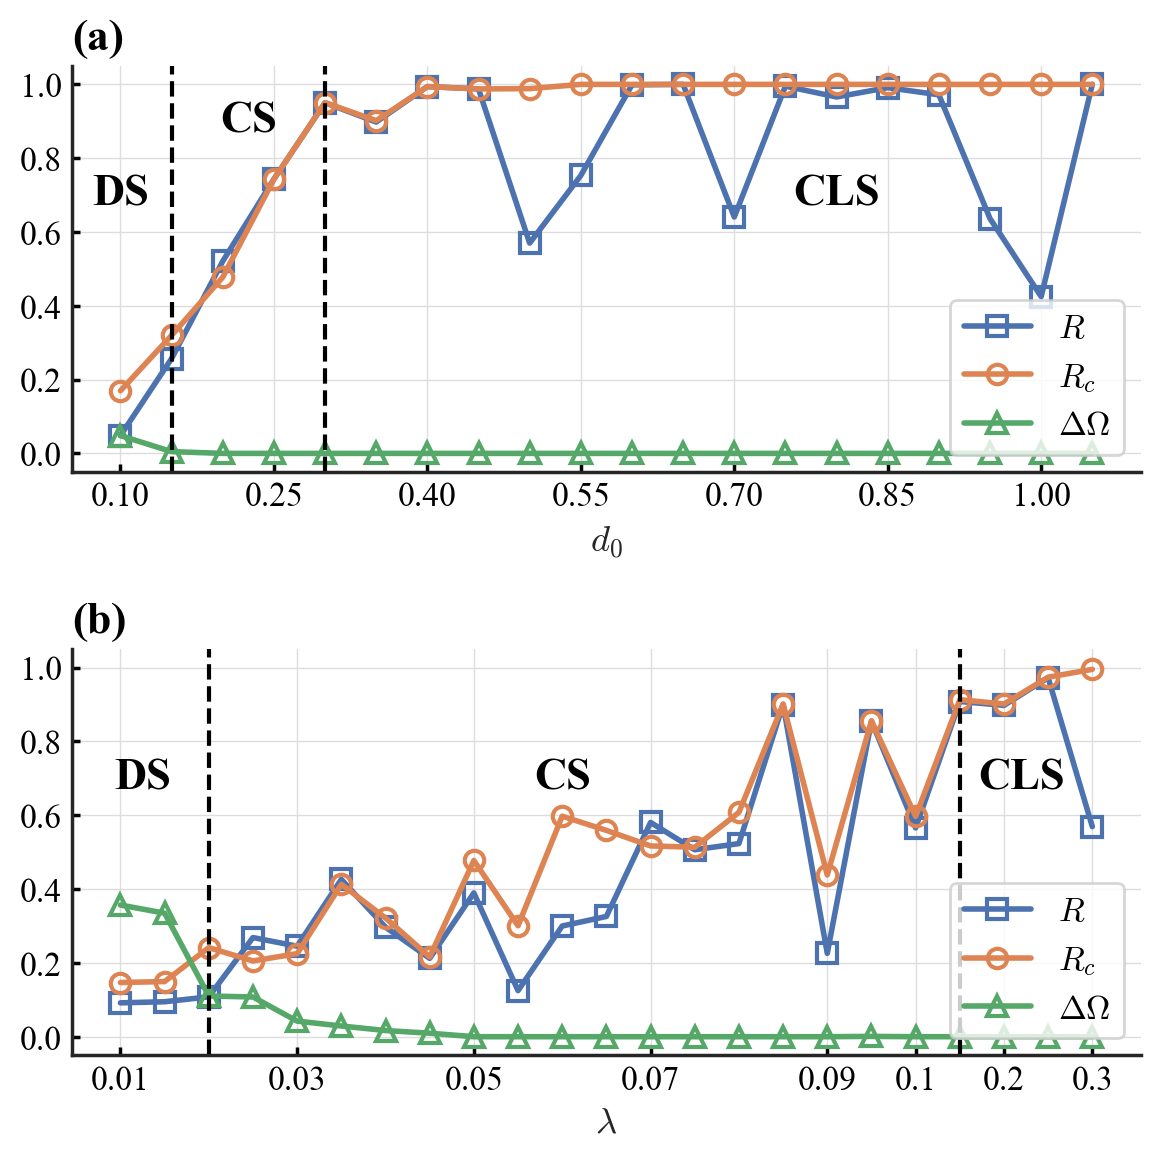

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
ax1, ax2 = axs.flatten()

mks = 7
mkfc = (0,0,1,0)

lookLambdaValue = 0.2
ax1.plot(maps1.columns, maps1.loc[lookLambdaValue], label=r"$R$", marker='s', lw=2, markerfacecolor=mkfc, markeredgecolor="C0", markersize=mks, markeredgewidth=1.5)
ax1.plot(maps2.columns, maps2.loc[lookLambdaValue], label=r"$R_c$", marker='o', lw=2, markerfacecolor=mkfc, markeredgecolor="C1", markersize=mks, markeredgewidth=1.5)
ax1.plot(maps3.columns, maps3.loc[lookLambdaValue], label=r"$\Delta\Omega$", marker='^', lw=2, markerfacecolor=mkfc, markeredgecolor="C2", markersize=mks, markeredgewidth=1.5)
ax1.set_xlabel(r"$d_0$", fontweight="bold")
ax1.set_title("(a)", loc="left", fontweight="bold", fontsize=16)
ax1.set_xticks(np.round(distanceDs, 2)[np.arange(len(distanceDs), step=3)])
ax1.axvline(x=0.15, color="black", linestyle="--", lw=1.5)
ax1.axvline(x=0.3, color="black", linestyle="--", lw=1.5)
ax1.text(0.1, 0.7, "DS", fontsize=16, fontweight="bold", ha="center", va="center")
ax1.text(0.225, 0.9, "CS", fontsize=16, fontweight="bold", ha="center", va="center")
ax1.text(0.8, 0.7, "CLS", fontsize=16, fontweight="bold", ha="center", va="center")

lookDistanceD0 = 0.35
ax2.plot(maps1[lookDistanceD0].values, label=r"$R$", marker='s', lw=2, markerfacecolor=mkfc, markeredgecolor="C0", markersize=mks, markeredgewidth=1.5)
ax2.plot(maps2[lookDistanceD0].values, label=r"$R_c$", marker='o', lw=2, markerfacecolor=mkfc, markeredgecolor="C1", markersize=mks, markeredgewidth=1.5)
ax2.plot(maps3[lookDistanceD0].values, label=r"$\Delta\Omega$", marker='^', lw=2, markerfacecolor=mkfc, markeredgecolor="C2", markersize=mks, markeredgewidth=1.5)
ax2.set_xlabel(r"$\lambda$", fontweight="bold")
opYIdxs = np.concatenate([np.arange(18, step=4), np.arange(18, 23, step=2)])
ax2.set_xticks(opYIdxs, np.round(rangeLambdas, 2)[opYIdxs])
ax2.set_title("(b)", loc="left", fontweight="bold", fontsize=16)
ax2.axvline(x=2, color="black", linestyle="--", lw=1.5)
ax2.axvline(x=19, color="black", linestyle="--", lw=1.5)
ax2.text(0.5, 0.7, "DS", fontsize=16, fontweight="bold", ha="center", va="center")
ax2.text(10, 0.7, "CS", fontsize=16, fontweight="bold", ha="center", va="center")
ax2.text(20.4, 0.7, "CLS", fontsize=16, fontweight="bold", ha="center", va="center")

for ax in axs.flatten():
    # ax.set_ylabel("Order Parameters")
    # ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True)
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig("./PJT_C_Fig/monoOpPlot.pdf", bbox_inches="tight")

In [43]:
lambda_c2(0.2)

0.20929235641769695

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


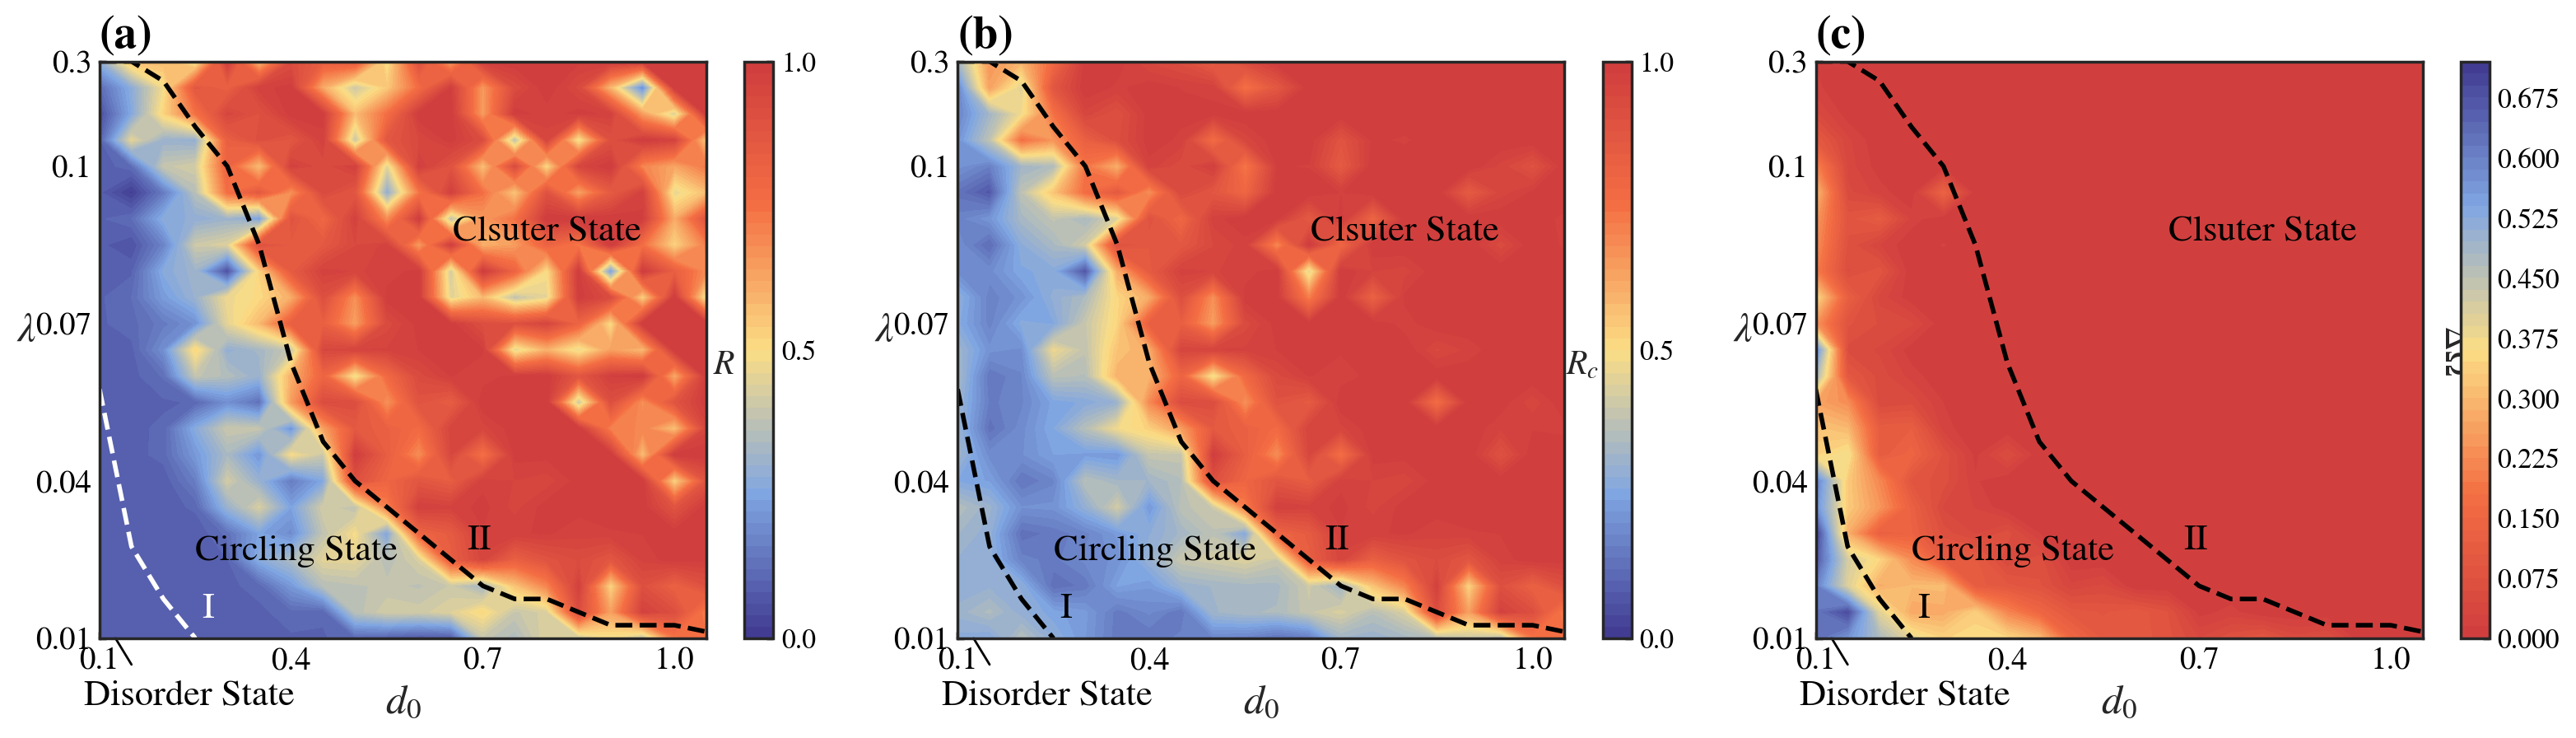

In [78]:
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
fig, ax = plt.subplots(1, 3, figsize=(16, 4.7))
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

level = 50
stdMaps1 = maps1.copy()
stdMaps1.iloc[0, 0] = 0
cf1 = ax[0].contourf(
    stdMaps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[0].contourf(
    maps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar1 = plt.colorbar(cf1, ax=ax[0], ticks=[0, 0.5, 1])
cbar1.set_label(r"$R$", fontsize=15, rotation=0, labelpad=-40)

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
cf2 = ax[1].contourf(
    stdMaps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[1].contourf(
    maps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar2 = plt.colorbar(cf2, ax=ax[1], ticks=[0, 0.5, 1])
cbar2.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar2.set_label(r"$R_c$", fontsize=15, rotation=0, labelpad=-40)

cf3 = ax[2].contourf(
    maps3, levels=level, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf3, ax=ax[2])
cbar3.set_label(r"$\Delta\Omega$", fontsize=15, rotation=-90, labelpad=-40)

mapColors = ["white", "black", "black"]
for i in range(3):
    ax[i].tick_params(direction='in', length=3)
    ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=14)
    ax[i].set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
    ax[i].set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
    ax[i].set_xlabel(r"$d_0$", fontsize=18)
    ax[i].set_ylabel(r"$\lambda$", rotation=0, fontsize=18)
    ax[i].set_title(f"({chr(97 + i)})", loc="left", 
                    fontdict={"fontsize": 20, "weight": "bold"})
    ax[i].plot(funcIdxs[lambda_c1][:4], label=r"$\lambda_{c1}(d_0)$",
               linestyle="--", color=mapColors[i], lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), line2, label=r"$\lambda_{c2}(d_0)$",
               linestyle="--", color="black", lw=2, zorder=2)
    ax[i].text(3, 3, "Circling State", fontsize=16, color="black")
    ax[i].text(-0.5, -2.5, "Disorder State", fontsize=16, color="black")
    ax[i].text(14, 15.5, "Clsuter State", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(3.2, 0.8, "I", fontsize=16, color=mapColors[i])
    ax[i].text(11.5, 3.4, "II", fontsize=16, color="black")
    ax[i].plot([1, 0.5], [-1, 0], clip_on=False, color="black", lw=1)
    ax[i].set_xlim(0, maps.shape[1] - 1)
    ax[i].set_ylim(0, maps.shape[0] - 1)

for cbar in [cbar1, cbar2, cbar3]:
    cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/monoOrderParam.png", bbox_inches="tight", dpi=300)

In [59]:
maps.shape[0] - 1

22

In [16]:
def plot_last_state(key: str, ax: plt.Axes = None, loadModel: bool = False, index: int = -1,
                    showTicks: bool = False, tickSize: int = 16, randomSeed: int = 10):
    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    if loadModel:
        l, d0 = key.split("_")
        l, d0 = float(l), float(d0)
        model = SpatialGroups(l, d0, speedV, savePath="./data", randomSeed=randomSeed)
        sa = StateAnalysis(model, showTqdm=False)
        singlePositionX, singlePhaseTheta, _ = sa.get_state(index=index)
    else:
        model = SingleDistribution(
            strengthLambda=0, distanceD0=0, boundaryLength=10,
            savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
        singlePositionX = positionX[key]
        singlePhaseTheta = phaseTheta[key]
    omegaTheta = model.omegaTheta

    ax.quiver(
        singlePositionX[:, 0], singlePositionX[:, 1],
        np.cos(singlePhaseTheta[:]), np.sin(singlePhaseTheta[:]), 
        color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
        scale=23, width=0.005
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if showTicks:
        ax.set_xticks([0, 5])
        ax.set_yticks([0, 5])
        ax.set_xlabel(r"$x$", fontsize=tickSize)
        ax.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
        ax.set_xticklabels(ax.get_xticks(), fontsize=tickSize)
        ax.set_yticklabels(ax.get_yticks(), fontsize=tickSize)
        # 拉近label与坐标轴的距离
        ax.xaxis.labelpad = -20
        ax.yaxis.labelpad = -10
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # ax.text(0.3, 9.2, "A", fontsize=20)
    # ax.text(9.2, 9.2, "B", fontsize=20)
    # ax.text(9.2, 0.3, "C", fontsize=20)
    # ax.text(0.3, 0.3, "D", fontsize=20)
    plt.tick_params(direction='in', length=3)


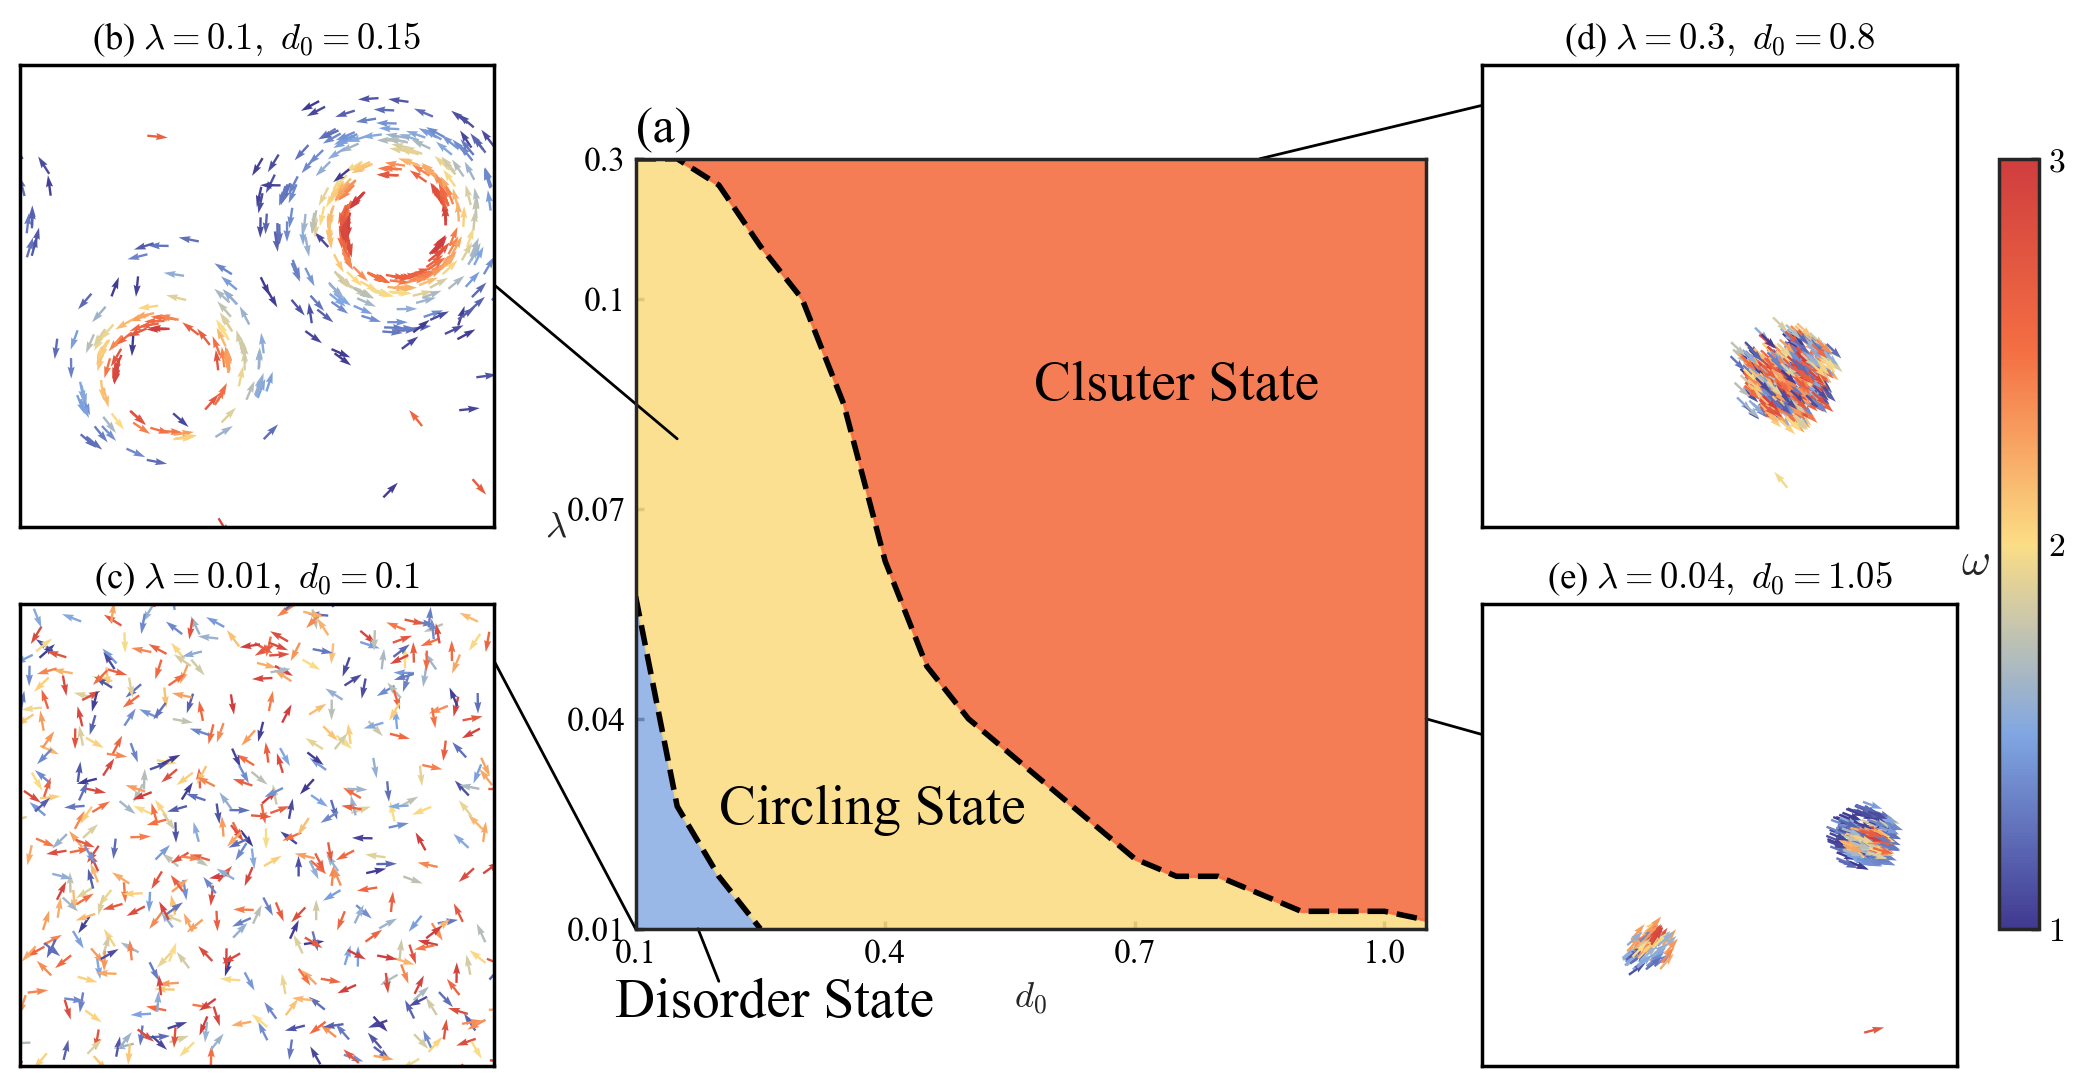

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5.1, 5))
maps1 = pd.read_excel("L5SingleDistributeR.xlsx", index_col=0)
# plt.contourf(maps1, levels=50, cmap=cmap)
plt.plot(funcIdxs[lambda_c1][:4], label=r"$\lambda_{c1}(d_0)$",
               linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), line2,
         linestyle="--", color="black", lw=2, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), 0, funcIdxs[lambda_c1], alpha=0.8, color="#80A6E2"
)

plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c1], line2, alpha=0.9, color="#FBDD85"
)
plt.fill_between(
    np.arange(maps.shape[1]), line2, len(rangeLambdas) - 1, alpha=0.9, color="#F46F43"
)

ax.plot([2, 1.5], [-1.5, 0], clip_on=False, color="black", lw=1)  # Disorder
ax.plot([-4, 0], [9, 0], clip_on=False, color="black", lw=1)
ax.plot([-4, 1], [19, 14], clip_on=False, color="black", lw=1)
ax.plot([19, 22], [6, 5], clip_on=False, color="black", lw=1)
ax.plot([15, 22], [22, 24], clip_on=False, color="black", lw=1)

plt.text(2, 3, "Circling State", fontsize=20, color="black")
plt.text(-0.5, -2.5, "Disorder State", fontsize=20, color="black")
plt.text(13, 15.5, "Clsuter State", ha="center", va="center", fontsize=20, color="black")

plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.tick_params(direction='in', length=3)

plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.grid(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axRing = inset_axes(ax, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(-0.8, 0.5, 1.5, 1.5),
                    bbox_transform=ax.transAxes)

plot_last_state(f"{0.1:.3f}_{0.15:.2f}", ax=axRing)
axRing.set_title(r"(b) $\lambda=0.1,\ d_0=0.15$")

axDisorder = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(-0.8, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
plot_last_state(f"{0.01:.3f}_{0.1:.2f}", ax=axDisorder)
axDisorder.set_title(r"(c) $\lambda=0.01,\ d_0=0.1$")

axQuickSync = inset_axes(ax, width="40%", height="40%", loc='lower left',
                         bbox_to_anchor=(1.05, 0.5, 1.5, 1.5),
                         bbox_transform=ax.transAxes)
plot_last_state(f"{0.3:.3f}_{0.8:.2f}", ax=axQuickSync)
axQuickSync.set_title(r"(d) $\lambda=0.3,\ d_0=0.8$")

axSwarm = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(1.05, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
plot_last_state(f"{0.04:.3f}_{1.05:.2f}", ax=axSwarm)
axSwarm.set_title(r"(e) $\lambda=0.04,\ d_0=1.05$")

colorbarAx = inset_axes(ax, width="5%", height="100%", loc='center',
                        bbox_to_anchor=(1.25, 0, 1, 1),
                        bbox_transform=ax.transAxes)
sca = ax.scatter(-np.ones_like(omegaTheta), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=cmap, s=100)
cbar = plt.colorbar(sca, cax=colorbarAx, ticks=[1, 2, 3])
cbar.ax.set_ylim(1, 3)
cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
cbar.set_label(r"$\omega$", fontsize=16, rotation=0)
cbar.ax.yaxis.set_label_coords(-0.6, 0.5)
cbar.ax.tick_params(direction='in', length=3)
ax.set_title(r"(a)", loc="left", fontsize=18)
# 保存为矢量图
plt.savefig("./PJT_C_Fig/monoChiralPhaseDiagram.pdf", bbox_inches="tight", dpi=300)

In [13]:
rangeLambdas

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.15 , 0.2  , 0.25 , 0.3  ])

In [14]:
np.where(distanceDs == distanceDs[-5]), np.where(rangeLambdas == rangeLambdas[-2])

((array([15], dtype=int64),), (array([21], dtype=int64),))

In [ ]:
# mono-chiral swarmalator
@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - (1 - (phaseTheta - 1) / 2) * 256).astype(np.int32)

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

idx = 1

fig = plt.figure(figsize=(len(rangeLambdas) * 4.5, len(distanceDs) * 5))

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SingleDistribution(
        strengthLambda=l, distanceD0=d0, boundaryLength=10,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    
    key = f"{l:.3f}_{d0:.2f}"
    # for i in range(1, 6):
    # try:
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    # except:
    #     continue

    omegaTheta = model.omegaTheta
    plt.quiver(
        lastPositionX[:, 0], lastPositionX[:, 1],
        np.cos(lastPhaseTheta[:]), np.sin(lastPhaseTheta[:]), 
        color=[cmap(i) for i in (omegaTheta - 1) / 2], scale=30, width=0.004
    )
    plt.scatter(lastPositionX[:, 0], lastPositionX[:, 1],
                c=omegaTheta, cmap=new_cmap, alpha=0.8, vmin=1, vmax=3, s=0.01)

    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_ylim(1, 3)
    cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)    
    ax.set_title(f"{l:.3f}_{d0:.2f}")
    
    idx += 1

plt.savefig("SingleDistributionBigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

In [108]:
model = SingleDistribution(
        strengthLambda=0.1, distanceD0=0.15, boundaryLength=10, tqdm=True,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True) 

In [109]:
model.run(60000)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
savePath = "./data"
mp4Path = "./mp4"

def draw_mp4(model: SingleDistribution):

    targetPath = f"{savePath}/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    omegaTheta = model.omegaTheta

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[:, 0], positionX[:, 1],
            np.cos(phaseTheta), np.sin(phaseTheta), 
            color=[cmap(i) for i in (omegaTheta - 1) / 2], alpha=1,
            scale=23, width=0.005
        )
        ax1.set_xlim(0, model.boundaryLength)
        ax1.set_ylim(0, model.boundaryLength)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta, bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")
        ax2.set_zlim(0, model.agentsNum)

    TNum = 100
    pbar = tqdm(total=TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum, 1), interval=50, repeat=False)
    ani.save(f"{mp4Path}/{model}.mp4", dpi=150)
    plt.close()

    pbar.close()

In [ ]:
draw_mp4(model)

In [ ]:
targetPath = f"{savePath}/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

In [ ]:
totalPointTheta

In [ ]:
plt.plot(totalPositionX[:, 3, 0], totalPositionX[:, 3, 1])
plt.xlim(0, 5)
plt.ylim(0, 5)

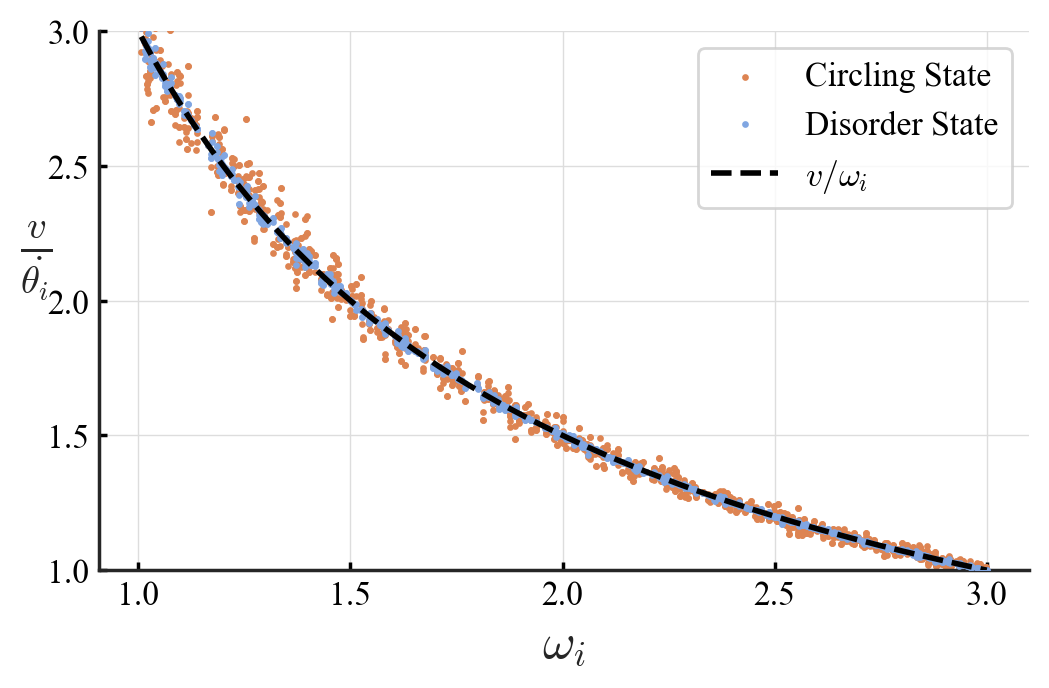

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 3.5))
tickSize = 18

rangeLambdas = np.arange(0.03, 0.041, 0.01)
distanceDs = [0.1]

for rangeLambda in rangeLambdas:
    model = SingleDistribution(strengthLambda=rangeLambda, distanceD0=0.2, boundaryLength=10, 
                               tqdm=False, savePath="./data", randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="C1", zorder=2)
    if rangeLambda == rangeLambdas[-1]:
        # legend = False
        # ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Analytical")
        ax1.scatter(omegaTheta, distances, label="Circling State", s=2, color="C1", zorder=2)
        ax1.legend(frameon=True, facecolor="white")

rangeLambdas = [0.01, 0.02]
distanceDs = [0.1]

for rangeLambda in rangeLambdas:
    
    model = SingleDistribution(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=10, 
                               tqdm=False, savePath="./data", # distributType="uniform", 
                               randomSeed=10, overWrite=True)
    l, d0 = model.strengthLambda, model.distanceD0
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = np.abs(model.omegaTheta)
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    ax1.scatter(omegaTheta, distances, s=2, color="#80A6E2", zorder=3)
    if rangeLambda == rangeLambdas[-1]:
        ax1.scatter(omegaTheta, distances, label="Disorder State", s=2, color="#80A6E2", zorder=0)
        ax1.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=2, label=r"$v/\omega_i$", zorder=3)
        ax1.legend(frameon=True, facecolor="white")

ax1.set_ylim(1, 3)
ax1.set_yticks([1, 1.5, 2, 2.5, 3])
ax1.set_xticks([1, 1.5, 2, 2.5, 3])
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.grid(True)
ax1.set_ylabel(r"$\frac{v}{\dot{\theta_i}}$", fontsize=tickSize + 2, rotation=0)
ax1.set_xlabel(r"$\omega_i$", fontsize=tickSize)
ax1.tick_params(direction='in', length=3)
plt.savefig("./PJT_C_Fig/Radii.pdf", bbox_inches="tight")

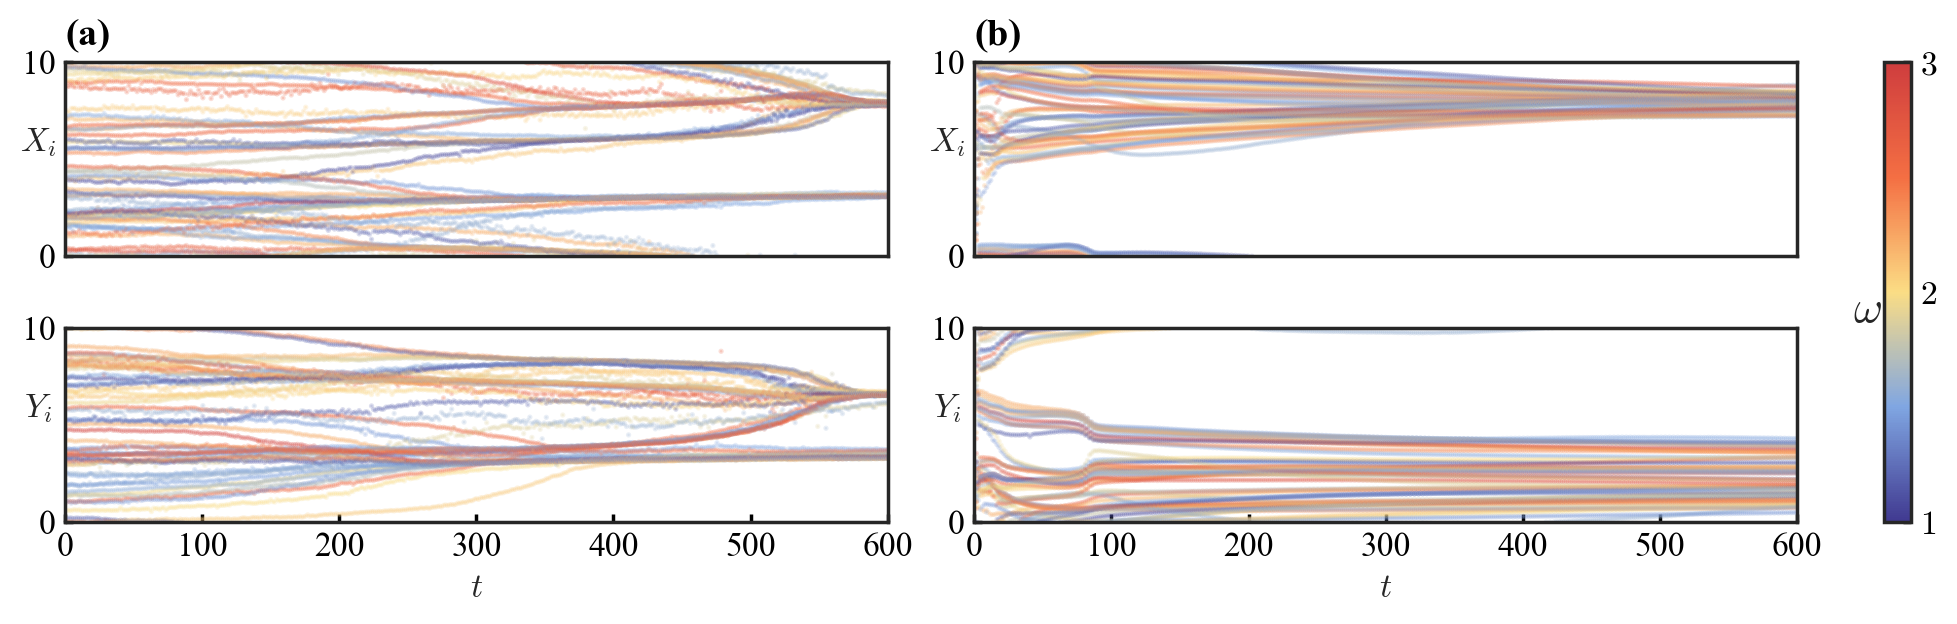

In [7]:
_ = plt.figure(figsize=(10, 5 / 3 * 2))

fontSize = 12

model = SingleDistribution(
        strengthLambda=0.1, distanceD0=0.15, boundaryLength=10, tqdm=True,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True) 
colWide = 16
ax1Row1 = plt.subplot2grid((2, colWide + 1), (0, 0), colspan=colWide // 2)
ax1Row2 = plt.subplot2grid((2, colWide + 1), (1, 0), colspan=colWide // 2)
ax1Row1.tick_params(direction='in', length=3)
ax1Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)
cp1[:, 0] = cp1[:, 0]

# s = 0.2
# alpha = 0.5
s = 0.8
alpha = 0.2
step = 10
dt = 0.01
labelpad = -6

np.random.seed(10)
omegaTheta = np.random.uniform(1, 3, size=500)
color = [cmap(i) for i in (omegaTheta - 1) / 2]
color1 = np.array(color * (cp1.shape[0] // 500))  # "#FF5B5E"

idx = np.arange(cp1.shape[0], step=step)
ax1Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=color1[idx])  # 
ax1Row1.set_ylim(0, 10)
ax1Row1.set_xlim(0, 12000 * dt * 5)
ax1Row1.set_xticks([])
ax1Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row1.set_title("(a)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax1Row1.set_yticks([0, 10])
ax1Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=color1[idx])  # 
ax1Row2.set_ylim(0, 10)
ax1Row2.set_xlim(0, 12000 * dt * 5)
ax1Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax1Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row2.set_yticks([0, 10])

model = SingleDistribution(
        strengthLambda=0.3, distanceD0=1, boundaryLength=10, tqdm=True,
        savePath="./data", distributType="uniform", randomSeed=10, overWrite=True) 
ax2Row1 = plt.subplot2grid((2, colWide + 1), (0, colWide // 2), colspan=colWide // 2)
ax2Row2 = plt.subplot2grid((2, colWide + 1), (1, colWide // 2), colspan=colWide // 2)
ax2Row1.tick_params(direction='in', length=3)
ax2Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)

color2 = "#77A4DE"
cp1[:, 0] = cp1[:, 0]

idx = np.arange(cp1.shape[0], step=step)
ax2Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=color1[idx])  #
ax2Row1.set_ylim(0, 10)
ax2Row1.set_xlim(0, 12000 * dt * 5)
ax2Row1.set_xticks([])
ax2Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row1.set_title("(b)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax2Row1.set_yticks([0, 10])
sca = ax2Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=color1[idx])  #
ax2Row2.set_ylim(0, 10)
ax2Row2.set_xlim(0, 12000 * dt * 5)
ax2Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax2Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row2.set_yticks([0, 10])

colorbarAx = plt.subplot2grid((2, colWide + 1), (0, colWide), rowspan=2)
sca = ax2Row1.scatter(-np.ones_like(omegaTheta), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=cmap, s=100)
cbar = plt.colorbar(sca, cax=colorbarAx, ticks=[1, 2, 3])
cbar.ax.set_ylim(1, 3)
cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
cbar.set_label(r"$\omega$", fontsize=16, rotation=0, labelpad=-5)
cbar.ax.yaxis.set_label_coords(-0.6, 0.5)
cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout(w_pad=0)
# plt.savefig("./PJT_C_Fig/monoCentersPosition.png", bbox_inches="tight", dpi=200)